# The CP & TKD Decomposition with tensorly

이번 토이 코드에서는 `tensorfly`를 활용하여 CP & TKD Decomposition을 학습 해보겠습니다. 

## Remind 
<center><img src='https://www.researchgate.net/profile/Tai_Xiang_Jiang2/publication/321902217/figure/fig1/AS:613931840180273@1523384165986/The-illustration-of-a-Tucker-decomposition-and-b-CP-factorization-of-an-n-1-n-2-n.png' width=70%></center>


# Iinstall package 
```python
!pip install tensorly -y
```

In [ ]:
!pip install tensorly 

     |████████████████████████████████| 112kB 4.3MB/s 
     |████████████████████████████████| 163kB 5.7MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.1-cp36-none-any.whl size=149171 sha256=1fd3ef1f1afcc67208d26a9a603f4dfd791c2c7a83ff3e696d6e6c69e99eac9c
  Stored in directory: /root/.cache/pip/wheels/88/1e/e7/b9677b2046cc87e17931b4b5781941786d3ee647825ca40ea6
Successfully built tensorly


# Import libraries

In [ ]:
import numpy as np
import tensorly as tl
from tensorly.random import check_random_state
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.decomposition import parafac, tucker
import torch
import warnings
from torch.autograd import Variable
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

# switch to the PyTorch backend
tl.set_backend('pytorch')

# fix the random seed to make things consistent
np.random.seed(42)

# Set hyperparameters

In [ ]:
# set value 
SEED = 42
ITERATION = 10000
LEARNING_RATE = 1e-4 
RANK = 4

# Define X

In [ ]:
# Define inital tensor(X)
tensor = np.random.randint(1,5, size=(5, 5, 5)) # shape = [5, 5, 5]
X = Variable(tl.tensor(tensor), requires_grad=True)
print('Generate a 5 x 5 x 5 array of ints between 1 and 4 as below:')
print('X:',X)

Generate a 5 x 5 x 5 array of ints between 1 and 4 as below:
X: tensor([[[3., 4., 1., 3., 3.],
         [4., 1., 1., 3., 2.],
         [3., 3., 3., 3., 4.],
         [1., 4., 4., 4., 3.],
         [2., 1., 2., 4., 4.]],

        [[2., 2., 2., 4., 4.],
         [1., 1., 4., 2., 2.],
         [1., 4., 1., 1., 3.],
         [3., 3., 2., 4., 4.],
         [4., 4., 3., 2., 2.]],

        [[3., 2., 3., 4., 3.],
         [4., 4., 1., 3., 1.],
         [3., 3., 1., 1., 3.],
         [2., 4., 1., 4., 2.],
         [2., 2., 1., 2., 1.]],

        [[2., 4., 4., 3., 4.],
         [3., 4., 1., 4., 3.],
         [3., 2., 1., 4., 2.],
         [4., 4., 2., 2., 2.],
         [2., 2., 4., 2., 1.]],

        [[3., 2., 2., 4., 2.],
         [2., 2., 4., 2., 3.],
         [4., 3., 4., 2., 3.],
         [4., 1., 2., 4., 1.],
         [4., 1., 2., 3., 1.]]], requires_grad=True)


# Class




In [ ]:
# class 
class Trainer:
    def __init__(self, X, rank, epoch, lr,method):
        self.method = method
        self.X = X
        self.rank = rank
        self.lr = lr
        self.decompo_method = {'cpd':parafac, 'tkd':tucker}
        self.reconst_method = {'cpd':tl.kruskal_to_tensor, 'tkd':tl.tucker_to_tensor}
        self.decompo_recon()

    def decompo_recon(self):
        '''
        method: cpd(cp-decomposition) & tkd(tuncker decomposition)
        return: weights, factors
        '''
        weights, factors = self.decompo_method[self.method](self.X, self.rank)
        self.weights = Variable(weights, requires_grad=True) 
        self.factors = [Variable(f,requires_grad=True) for f in factors]
        return None
        
    def train(self):
        print("training start!\n")
        print('-'*10)
        print("Method:",self.method)
        print("rank:", self.rank)
        print('-'*10)

        optimizer = torch.optim.Adam([self.weights]+self.factors, lr=self.lr)
        losses = []
        for i in range(1, ITERATION):
            # Important: do not forget to reset the gradients
            optimizer.zero_grad()

            # Reconstruct the tensor from the decomposed form
            X_tilde = self.reconst_method[self.method]((self.weights, self.factors)) 


            loss = torch.mean((self.X - X_tilde)**2) # MSE loss
            losses.append(loss.item())

            loss.backward(retain_graph=True)
            optimizer.step()

            if i % 1000 == 0:
                print("Epoch %s | Rec. error: %.9f" % (i, loss.item()))
        
        print('-'*10)
        plt.plot(losses)
        plt.title(f'Learning Curve of {self.method.upper()}')
        plt.ylabel('loss over time')
        plt.xlabel('iteration times')
        plt.show()
        return None

# Main

training start!

----------
Method: cpd
rank: 4
----------
Epoch 1000 | Rec. error: 0.583448946
Epoch 2000 | Rec. error: 0.583297849
Epoch 3000 | Rec. error: 0.583177745
Epoch 4000 | Rec. error: 0.583066046
Epoch 5000 | Rec. error: 0.582953036
Epoch 6000 | Rec. error: 0.582837284
Epoch 7000 | Rec. error: 0.582720518
Epoch 8000 | Rec. error: 0.582603872
Epoch 9000 | Rec. error: 0.582487583
----------


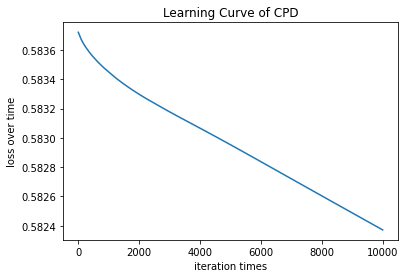

In [ ]:
# cpd 
trainer = Trainer(X,rank=RANK,lr=LEARNING_RATE,epoch=ITERATION,method='cpd')
trainer.train()

training start!

----------
Method: tkd
rank: 4
----------
Epoch 1000 | Rec. error: 0.312308371
Epoch 2000 | Rec. error: 0.312308341
Epoch 3000 | Rec. error: 0.312308371
Epoch 4000 | Rec. error: 0.312308341
Epoch 5000 | Rec. error: 0.312308401
Epoch 6000 | Rec. error: 0.312308371
Epoch 7000 | Rec. error: 0.312308341
Epoch 8000 | Rec. error: 0.312308401
Epoch 9000 | Rec. error: 0.312308341
----------


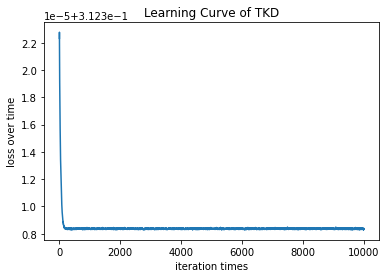

In [ ]:
# tkd
trainer = Trainer(X,rank=RANK,lr=LEARNING_RATE,epoch=ITERATION,method='tkd')
trainer.train()

----
## 밑에 코드 삭제 예정


# The CP Decomposition with tensorly


In [ ]:
import numpy as np
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
np.random.seed(42)
np.set_printoptions(precision=2, suppress=True)

In [ ]:
# set inital tensor 
tensor = np.random.random((10, 10, 10, 10))

In [ ]:
# cp-decompo.
weights, factors = parafac(tensor, rank=2)
[f.shape for f in factors]

AttributeError: ignored

In [ ]:
print('Compression ratio:', 1-((10*2)*4) / (10**4))

In [ ]:
full_tensor = tl.kruskal_to_tensor((weights, factors))

NameError: ignored

In [ ]:
from sklearn.metrics import mean_absolute_error
print('error:', mean_absolute_error(tensor.reshape(-1),full_tensor.reshape(-1)))

# The CP Decomposition

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
import tensorly as tl
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.random import check_random_state
# Using mxnet backend.

In [ ]:
# switch to the PyTorch backend
tl.set_backend('pytorch')

In [ ]:
# set initial value 
random_state = 42
rng = check_random_state(random_state)

In [ ]:
# Define a initial tensor
shape = [5, 5, 5]
tensor = Variable(tl.tensor(rng.random_sample(shape)), requires_grad=True)
X = tensor

In [ ]:
ranks = [5, 5, 5]
core = Variable(tl.tensor(rng.random_sample(ranks)), requires_grad=True)
factors = [Variable(tl.tensor(rng.random_sample((tensor.shape[i], ranks[i]))),
                    requires_grad=True) for i in range(tl.ndim(tensor))]

In [ ]:
I'm# n_iter = 10
# lr = 0.00005
# penalty = 0.1

# optimizer = torch.optim.Adam([core]+factors, lr=lr)

# for i in range(1, n_iter):
#     # Important: do not forget to reset the gradients
#     optimizer.zero_grad()

#     # Reconstruct the tensor from the decomposed form
#     rec = tucker_to_tensor(core, factors)

#     # squared l2 loss
#     loss = (rec - tensor).pow(2).sum()

#     # squared l2 penalty on the factors of the decomposition
#     for f in factors:
#         loss = loss + penalty * f.pow(2).sum()

#     loss.backward()
#     optimizer.step()

#     if i % 1000 == 0:
#         rec_error = tl.norm(rec.data - tensor.data, 2)/tl.norm(tensor.data, 2)
#         print("Epoch %s,. Rec. error: %s" % (i, rec_error))

In [ ]:
def construct(A,B,C):
    """
    Given Matrices A, B, C construct 3D Tensor 
        A : i, r
        B: j, r
        C : k, r
    """
    X_tilde = 0
    r = A.shape[1]
    for i in range(r):
        X_tilde += torch.ger(A[:,i], B[:,i]).unsqueeze(2)*C[:,i].unsqueeze(0).unsqueeze(0)
    return X_tilde

def CP_decomposition(factors, max_iter=10000, lr=0.1):
    """
    factors=[A,B,C]
    Minimize Frobenius Norm |X-X_tilde|
    Update decomposition factors
    """
    opt = torch.optim.Adam(factors, lr=lr)
    losses = []
    for i in range(max_iter):    
        X_tilde = construct(*factors)

        opt.zero_grad()
        loss = torch.mean((X - X_tilde)**2)
        #print(loss)
        losses.append(loss.item())

        loss.backward(retain_graph=True)
        opt.step()
    return losses

In [ ]:
losses = CP_decomposition(factors, max_iter=10000, lr=0.1)

Learning curve for rank 5 


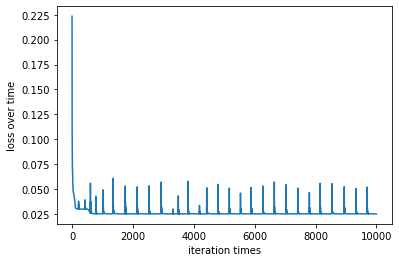

In [ ]:
import matplotlib.pyplot as plt
print('Learning curve for rank 5 ')
plt.plot(losses)
plt.ylabel('loss over time')
plt.xlabel('iteration times')
plt.show()

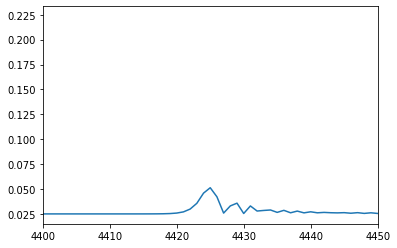

In [ ]:
plt.xlim([4400,4450])
plt.plot(losses)
plt.show()

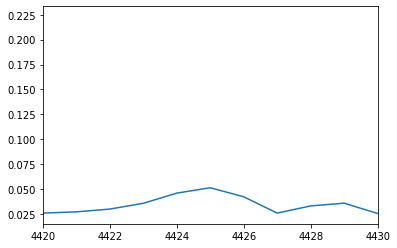

In [ ]:
plt.xlim([4420,4430])
plt.plot(losses)
plt.show()